# Resnet152
### 94.27% accuracy TTA accuracy and 93.57% accuracy on test set with 35 epochs
### Weighted Precision 93.83% and weighted Recall 93.57%
 
Model is trained with **35 epochs** and has a **94.27% accuracy** on the test set, accuracy is achieved due to a different approach of training with **progressive resizing** and training with **rectangular images** based on the median of the aspect ratio of all images

#### On training with rectangular images
Training dataset is initiated with square 299x299 images followed by 299x400, and then testing with same rectangular images, achieving **94.27%** of TTA accuracy in 35 epochs. 

#### Data Augmentation 
Perhaps the most important step that is essential in providing a better accuracy. Together with **progressive resizing** and **rectangular images training**, I have also used the default fastai images transformation, performed by calling `get_transforms()` that randomly augments the images according to their parameters: 
`do_flip` : perform flipping with probability of 0.5. I chose the default value **True** for this parameter <br>
`flip_ver` : if True flip images vertically instead, I chose **False** as it doesn't help to have a vertically flipped images<br>
`max_rotate`: I chose up to **10.0** degree rotation at random, <br>
`max_zoom`: default value of up to **1.1** zoom<br>
`max_lighting`: default value of up to **0.2** of increase/decrease in brightness or contrast<br>
`max_warp`:  default value of **0.2**<br>
`p_affine` : Probability of randomly applying affine, default value **0.75**<br>
`p_lighting` : probability of applying lighting transform, default value **0.75** <br>

During resizing, instead of cropping the images to the target size, I chose to squished/compress the images into the target size to keep the features of the images during training.

In [3]:
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *

In [4]:
train_path = 'data/all_train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
CROPPED_PATH = Path(cropped_path)

#### Commence training: Stage-1 (resnet152)
- Setting up data bunch and transformations

In [5]:
tfms = get_transforms()

In [6]:
trn_df_labels = pd.read_csv('train_all.csv',usecols=['filename','class_name'])

In [7]:
src = (ImageList
       .from_df(trn_df_labels,train_path, cols='filename')
       .split_by_rand_pct(0.2, seed=42) #Splitting to 80:20 train-val set
       .label_from_df('class_name')) #Adding the labels to the data from the df

In [11]:
data299 = (src
           .transform(tfms,size=(299,299)) #adding transformation and resizing all images to 299x299
           .databunch(bs=12) #Using batch size of 12
           .normalize(imagenet_stats)) #Normalizing the databunch to imagenet_stats

In [7]:
#Initializing the Learner by loading the data, the model and metrics required for training
learn = cnn_learner(data299, models.resnet152, metrics=[error_rate, accuracy, Precision(average='weighted'), Recall(average='weighted')]) 

Train for 5 epochs using Leslie Smith's fit one cycle, where overtime increasing the lr before decreasing back the lr and inversely for momentum can lead to super convergence faster. 

The most common ways to train a pretrained model is to remove the last layer and train the whole architecture with the pretrained weights, followed by unfreezing the rest of the model and updating the weight on the data. 

The choice of learning rate 1e-3 is chosen because a low learning rate is essential to not destroy the weights of the pretrained model

In [8]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,3.383384,2.533082,0.529321,0.470679,nan,0.470679,09:55
1,1.609173,1.031370,0.254836,0.745164,nan,0.745164,09:48
2,0.927870,0.534967,0.139392,0.860608,0.878689,0.860608,09:48
3,0.578842,0.332476,0.083512,0.916488,0.923546,0.916488,09:48
4,0.433682,0.294121,0.076144,0.923856,0.928767,0.923856,09:48


### Stage 2
Unfreezing the rest of the layers

In [9]:
learn.unfreeze()

Training for 10 more epochs with learning rate betwee 1e-5 and 1e-3

In [ ]:
learn.fit_one_cycle(10,slice(1e-5,1e-3))

Saving the model

In [11]:
learn.save('14-resnet152-v1')

lr_find() is used as a quick way to plot learning rate against loss and in the chart, learning rate from 1e-6 to 1e-4 seems to be a good learning rate based on the chart to minimise training loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


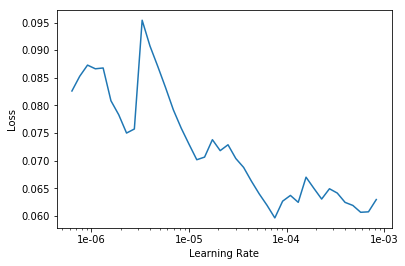

In [12]:
learn.lr_find()
learn.recorder.plot()

Training it for another 5 epochs based on the learning rate chosen from the chart

In [13]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.045991,0.113032,0.033159,0.966841,0.968447,0.966841,13:07
1,0.045217,0.104740,0.028861,0.971139,0.972654,0.971139,13:08


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
learn.save('14-resnet152-v2')

Initial EDA shows that median aspect ratio in the dataset is 3:4 and it is an important information because most model is trained with squared image and it will not work with a rectangular images. FastAI library made it easier to train with a custom aspect ratio, allowing the model to be trained on rectangular images. 
Reason why square images do not work is because, when images are resized to squares, depending on the resizing method, the images either were:

1. made the images look squished 
2. cropped into the middle, losing other features for the whole image

Hence training it with images with **3:4 aspect ratio** will retain a lot of the features of the car. 

In [15]:
data_ar = (src
           .transform(tfms,size=(299,400)) #299,400 to retain the 3:4 aspect ratio
           .databunch(bs=12) 
           .normalize(imagenet_stats))

Swapping out the data in the Learner object with new rectangular images for training

In [16]:
learn.data = data_ar 

In [17]:
learn.freeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


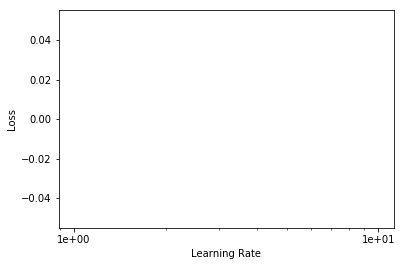

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5,2e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.033748,0.100106,0.027633,0.972367,0.973969,0.972367,12:46
1,0.042216,0.102050,0.027633,0.972367,0.974001,0.972367,12:43


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Unfreezing to train the whole model and its weights

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


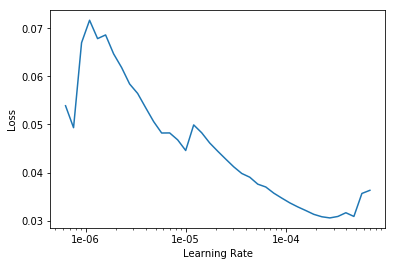

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10,slice(3e-7,3e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.049646,0.097745,0.026712,0.973288,0.974911,0.973288,16:52
1,0.048838,0.102180,0.027940,0.972060,0.973771,0.972060,16:53
2,0.027744,0.099364,0.027633,0.972367,0.973759,0.972367,16:53
3,0.036963,0.094732,0.027019,0.972981,0.974558,0.972981,16:53
4,0.034997,0.096316,0.026405,0.973595,0.975079,0.973595,16:55
5,0.027745,0.095501,0.027940,0.972060,0.973548,0.972060,16:54
6,0.023841,0.093925,0.025791,0.974209,0.975729,0.974209,16:54
7,0.030853,0.091728,0.027326,0.972674,0.974083,0.972674,16:54
8,0.024859,0.097823,0.028247,0.971753,0.973370,0.971753,16:53


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Saving the model to be used for testing

In [24]:
learn.save('14-resnet152-v3')

### Testing

Load test dataset

In [8]:
all_img_df = pd.read_csv('all_img.csv', usecols=['filename','class_name', 'test'])

Loading a test image, test set is used in the dataloader validation set

In [9]:
data_test = (ImageList
             .from_df(all_img_df,all_img_path,cols='filename')
             .split_from_df(col='test')
             .label_from_df(cols='class_name')
             .transform(tfms,size=(299,400))
             .databunch(bs=64)
             .normalize(imagenet_stats))

In [19]:
learn = cnn_learner(data299,models.resnet152,metrics=[error_rate,accuracy,top_k_accuracy, prec, rec])

In [20]:
learn.load('14-resnet152-v3');

In [21]:
learn.data = data_test

In [22]:
prec = Precision(average='weighted')
prec.n_classes = 0
rec = Recall(average='weighted')
rec.n_classes = 0


In [23]:
learn.validate()

[0.27767804,
 tensor(0.0643),
 tensor(0.9357),
 tensor(0.9913),
 tensor(0.9383),
 tensor(0.9357)]

In [47]:
#rectangular
test_preds, test_ys = learn.TTA()

In [48]:
accuracy(test_preds,test_ys)

tensor(0.9427)